In [1]:
import numpy as np

from ase import Atoms, units
from ase.units import Angstrom
from ase.calculators.lj import LennardJones
from ase.optimize import BFGS
from ase.constraints import FixedPlane
from ase.visualize import view

from math import sqrt, exp

import matplotlib.pyplot as plt

## 3 Initial cluster setup
### 3.1 2D and 3D clusters with 7 atoms

In [2]:
def R(θ):
    """
    2D Rotation matrix for counterclockwise
    rotaion by θ around origin 
    """
    return np.array([[np.cos(θ), -np.sin(θ)]
                    ,[np.sin(θ),  np.cos(θ)]])

In [3]:
a = 1.1 * Angstrom
positions = np.zeros((7,3))
positions[1:,0] = a

rotations = np.array([np.linalg.matrix_power(R(np.pi/3),n) for n in range(6)])

positions[1:,:2] = np.einsum('ijk,ik->ij', rotations, positions[1:,:2])

In [4]:
cluster_2d = Atoms('7Ar',positions)
view(cluster_2d, viewer='x3d')

In [5]:
positions = np.zeros((7,3))
positions[[1,2],2] = a, -a
positions[3:,0] = a

rotations = np.array([np.linalg.matrix_power(R(np.pi/2),n) for n in range(4)])

positions[3:,:2] = np.einsum('ijk,ik->ij', rotations, positions[3:,:2])

In [6]:
cluster_3d = Atoms('7Ar',positions)
view(cluster_3d, viewer='x3d')

In [7]:
cluster_2d.calc = LennardJones()
cluster_3d.calc = LennardJones()

print('2D cluster:\npotential energy = %e [ε] \ninitial positions [Angstrom]:\n%s\n'
      %(cluster_2d.get_potential_energy(),cluster_2d.get_positions()))

print('3D cluster:\npotential energy = %e [ε] \ninitial positions [Angstrom]:\n%s\n'
      %(cluster_3d.get_potential_energy(),cluster_3d.get_positions()))

2D cluster:
potential energy = -1.228157e+01 [ε] 
initial positions [Angstrom]:
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.10000000e+00  0.00000000e+00  0.00000000e+00]
 [ 5.50000000e-01  9.52627944e-01  0.00000000e+00]
 [-5.50000000e-01  9.52627944e-01  0.00000000e+00]
 [-1.10000000e+00  4.55774961e-16  0.00000000e+00]
 [-5.50000000e-01 -9.52627944e-01  0.00000000e+00]
 [ 5.50000000e-01 -9.52627944e-01  0.00000000e+00]]

3D cluster:
potential energy = -9.037942e+00 [ε] 
initial positions [Angstrom]:
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.10000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -1.10000000e+00]
 [ 1.10000000e+00  0.00000000e+00  0.00000000e+00]
 [ 6.73555740e-17  1.10000000e+00  0.00000000e+00]
 [-1.10000000e+00  1.34711148e-16  0.00000000e+00]
 [-2.02066722e-16 -1.10000000e+00  0.00000000e+00]]



The default values of LJ parameters in ase are $\sigma=1$ and $\varepsilon=1$. Here $\sigma$ can be interpretten as the size of the particles and $\varepsilon$ is the potential depth.

### 3.2 Optimizing the initial cluster structures

In [8]:
for atom in cluster_2d:
    cluster_2d.set_constraint(FixedPlane(a=atom.index, direction=[0,0,1]))

cluster_2d_mini = BFGS(cluster_2d)
cluster_2d_mini.run(fmax=0.05)

print('2D cluster:\npotential energy = %e [ε] \npositions [Angstrom]:\n%s\n'
      %(cluster_2d.get_potential_energy(),cluster_2d.get_positions()))

cluster_3d_mini = BFGS(cluster_3d)
cluster_3d_mini.run(fmax=0.05)

print('3D cluster:\npotential energy = %e [ε] \npositions [Angstrom]:\n%s\n'
      %(cluster_3d.get_potential_energy(),cluster_3d.get_positions()))

      Step     Time          Energy         fmax
BFGS:    0 18:16:06      -12.281571        2.6446
BFGS:    1 18:16:06      -12.300262        1.9416
BFGS:    2 18:16:06      -12.415891        0.3876
BFGS:    3 18:16:06      -12.419639        0.0803
BFGS:    4 18:16:06      -12.419798        0.0025
2D cluster:
potential energy = -1.241980e+01 [ε] 
positions [Angstrom]:
[[-9.28125131e-16  8.75229936e-16 -4.68718085e-18]
 [ 1.11848102e+00 -1.86920528e-16 -1.42945281e-18]
 [ 5.59240510e-01  9.68632977e-01  7.90086046e-19]
 [-5.59240510e-01  9.68632977e-01  5.85319852e-19]
 [-1.11848102e+00  4.82495489e-16 -1.45987402e-19]
 [-5.59240510e-01 -9.68632977e-01  4.20336266e-19]
 [ 5.59240510e-01 -9.68632977e-01  0.00000000e+00]]

      Step     Time          Energy         fmax
BFGS:    0 18:16:06       -9.037942        1.1509
BFGS:    1 18:16:06       -9.087128        0.2280
BFGS:    2 18:16:06       -9.088710        0.0317
3D cluster:
potential energy = -9.088710e+00 [ε] 
positions [Angstrom]:

In [9]:
view(cluster_2d, viewer='x3d')

In [10]:
view(cluster_3d, viewer='x3d')

### 3.3 Pairwise distances

For a cluster with $N$ atoms there are $(N^2-N)/2$ pairwise distances without double counting. Therefore, for our clusters $(N=7)$ we have 21 distances.

In [11]:
def get_features(atoms):
    distances = atoms.get_all_distances()
    distances_wo_double = np.tril(distances).flatten()
    distnces_wo_double_wo_self = distances_wo_double[distances_wo_double>0]
    return distnces_wo_double_wo_self

In [12]:
get_features(cluster_2d)

array([1.11848102, 1.11848102, 1.11848102, 1.11848102, 1.93726595,
       1.11848102, 1.11848102, 2.23696204, 1.93726595, 1.11848102,
       1.11848102, 1.93726595, 2.23696204, 1.93726595, 1.11848102,
       1.11848102, 1.11848102, 1.93726595, 2.23696204, 1.93726595,
       1.11848102])

In [13]:
get_features(cluster_3d)

array([1.08627728, 1.08627728, 2.17255457, 1.08627728, 1.53622807,
       1.53622807, 1.08627728, 1.53622807, 1.53622807, 1.53622807,
       1.08627728, 1.53622807, 1.53622807, 2.17255457, 1.53622807,
       1.08627728, 1.53622807, 1.53622807, 1.53622807, 2.17255457,
       1.53622807])

## 4 Creating datasets using Monte Carlo sampling
### 4.1 MC sampling function

In [14]:
def mcmc_step(atoms, T:float, σ_G:float, D:int):
    
    n_atoms = len(atoms)
    beta = 1/(units.kB*T)
    accepted = 0
    
    atoms_old = atoms.copy()
    atoms_old.calc = LennardJones()
    positions_old = atoms_old.get_positions()
    E_pot_old = atoms_old.get_potential_energy()
    
    positions_new = positions_old.copy()
    positions_new[:,:D] += σ_G * np.random.randn(7,D)
    atoms_new = atoms_old.copy()
    atoms_new.calc = LennardJones()
    atoms_new.set_positions(positions_new)
    E_pot_new = atoms_new.get_potential_energy()
        
    acceptane_ratio = np.exp(-beta*(E_pot_new-E_pot_old))
        
    if acceptane_ratio > np.random.random():
        atoms_old = atoms_new.copy()
        atoms_old.calc = LennardJones()
        accepted += 1
        
    return atoms_old, accepted

def mcmc(atoms, T:float, σ_G:float, D:int
         ,n_step:int, report_step:int, write_step:int):
    
    trajectory = []
    acceptance_rate = 0

    for step in range(1,n_step+1):

        traj_step, accepted = mcmc_step(cluster_3d, T, σ_G, D)
        acceptance_rate += accepted / n_step

        if step%write_step == 0:
            trajectory.append(traj_step)

        if step%report_step == 0: 
            print('step: %5d, E_pot:%e ε'%(step, traj_step.get_potential_energy()))
            
    return trajectory, acceptance_rate

### 4.2 MC sampling and dataset for 3D LJ cluster

| T   | sigma    | acceptance rate |
|-----|----------|-----------------|
| 10  | 1.1e-3   | 0.4935          |
| 800 | 1.0e-2   | 0.5015          |

In [22]:
T_list = [10, 800]
σ_G_list = [1.1e-3, 1.0e-2]
D = 3

n_step = 20_000
report_step = 500
write_step = 20

dataset = {}

for T, σ_G in zip(T_list, σ_G_list):
    
    trajectory, acceptance_rate = mcmc(cluster_3d, T, σ_G, D
                                       ,n_step, report_step, write_step) 
    
    print('acceptance_rate = %g'%acceptance_rate)
    
    X = np.array(list(map(get_features,trajectory)))
    y = np.array(list(map(lambda atom: atom.get_potential_energy(),trajectory)))[:,np.newaxis]

    dataset[T] = (X,y)

step:   500, E_pot:-9.088502e+00 ε
step:  1000, E_pot:-9.088710e+00 ε
step:  1500, E_pot:-9.087897e+00 ε
step:  2000, E_pot:-9.088207e+00 ε
step:  2500, E_pot:-9.088710e+00 ε
step:  3000, E_pot:-9.087978e+00 ε
step:  3500, E_pot:-9.088150e+00 ε
step:  4000, E_pot:-9.087958e+00 ε
step:  4500, E_pot:-9.088710e+00 ε
step:  5000, E_pot:-9.088710e+00 ε
step:  5500, E_pot:-9.088165e+00 ε
step:  6000, E_pot:-9.088710e+00 ε
step:  6500, E_pot:-9.088448e+00 ε
step:  7000, E_pot:-9.088402e+00 ε
step:  7500, E_pot:-9.088710e+00 ε
step:  8000, E_pot:-9.088710e+00 ε
step:  8500, E_pot:-9.088710e+00 ε
step:  9000, E_pot:-9.088537e+00 ε
step:  9500, E_pot:-9.087542e+00 ε
step: 10000, E_pot:-9.088641e+00 ε
step: 10500, E_pot:-9.086393e+00 ε
step: 11000, E_pot:-9.088559e+00 ε
step: 11500, E_pot:-9.088710e+00 ε
step: 12000, E_pot:-9.088616e+00 ε
step: 12500, E_pot:-9.088710e+00 ε
step: 13000, E_pot:-9.088088e+00 ε
step: 13500, E_pot:-9.088710e+00 ε
step: 14000, E_pot:-9.088512e+00 ε
step: 14500, E_pot:-

[Text(0.5, 0, 'MC step'), Text(0, 0.5, 'potential energy [ε]'), (0.0, 1000.0)]

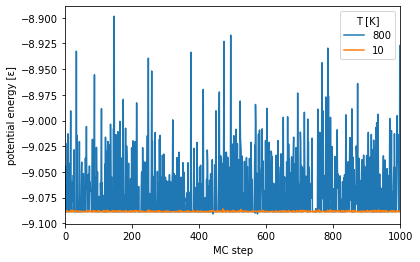

In [23]:
fig, ax = plt.subplots()

ax.plot(dataset[800][1][:,0], label=800)
ax.plot(dataset[10][1][:,0], label=10)

ax.legend(title='T [K]')
ax.set(xlabel='MC step', ylabel='potential energy [ε]'
      ,xlim=(0,n_step/write_step))

### 4.3 MC sampling and dataset for 2D LJ cluster

In [29]:
T_list = [200, 2000]
σ_G_list = [6.0e-3, 5.0e-2]
D = 2

n_step = 2_000
report_step = 500
write_step = 20

dataset = {}

for T, σ_G in zip(T_list, σ_G_list):
    
    trajectory, acceptance_rate = mcmc(cluster_2d, T, σ_G, D
                                       ,n_step, report_step, write_step) 
    
    print('acceptance_rate = %g'%acceptance_rate)
    
    X = np.array(list(map(get_features,trajectory)))
    y = np.array(list(map(lambda atom: atom.get_potential_energy(),trajectory)))[:,np.newaxis]

    dataset[T] = (X,y)

step:   500, E_pot:-9.063311e+00 ε
step:  1000, E_pot:-9.088710e+00 ε
step:  1500, E_pot:-9.085446e+00 ε
step:  2000, E_pot:-9.068230e+00 ε
acceptance_rate = 0.521
step:   500, E_pot:-9.088710e+00 ε
step:  1000, E_pot:-9.088710e+00 ε
step:  1500, E_pot:-9.088710e+00 ε
step:  2000, E_pot:-9.088710e+00 ε
acceptance_rate = 0.1105
